In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, confusion_matrix, classification_report
)


from sklearn.linear_model import LinearRegression, LogisticRegression

First, we need to read in our data, clean it, and select the appropriate columns for our analysis

In [4]:
football_data = pd.read_csv("play_by_play_2025.csv")
football_data.head()

/tmp/ipykernel_22287/1773864980.py:1: DtypeWarning: Columns (0: two_point_conv_result, 1: lateral_receiver_player_id, 2: lateral_receiver_player_name, 3: lateral_rusher_player_id, 4: lateral_rusher_player_name, 5: lateral_interception_player_id, 6: lateral_interception_player_name, 7: own_kickoff_recovery_player_id, 8: own_kickoff_recovery_player_name, 9: blocked_player_id, 10: blocked_player_name, 11: forced_fumble_player_2_team, 12: forced_fumble_player_2_player_id, 13: forced_fumble_player_2_player_name, 14: solo_tackle_2_team, 15: solo_tackle_2_player_id, 16: solo_tackle_2_player_name, 17: assist_tackle_3_player_id, 18: assist_tackle_3_player_name, 19: assist_tackle_3_team, 20: assist_tackle_4_player_id, 21: assist_tackle_4_player_name, 22: assist_tackle_4_team, 23: fumbled_2_player_id, 24: fumbled_2_player_name, 25: fumbled_2_team, 26: fumble_recovery_2_team, 27: fumble_recovery_2_player_id, 28: fumble_recovery_2_player_name, 29: safety_player_name, 30: safety_player_id) have mixe

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,NaN,NaN,NaN,...,0,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0,0,-0.352700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0,0,-0.190052,NaN,NaN,NaN,NaN,NaN,0.511128,-51.112807
3,85,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,1,0,1.317340,0.939998,4.750889,3.0,0.666726,0.43911,0.668940,33.105969
4,115,2025_01_ARI_NO,2025090705,NO,ARI,REG,1,ARI,away,NO,...,0,0,-1.694360,NaN,NaN,NaN,NaN,NaN,0.492038,50.796208


In this dataset, each row is a single play. The features of this dataset are a wide variety of information about that particular play. There are string columns that contain which teams are playing like `home_team`, there are integer columns that contain information about the given game in the NFL calendar like `week`, and there are boolean columns like `out_of_bounds` that contain a 1 if the play ended with the ball getting run out of bounds / or not. 

For our analysis, it will be really important to only include features that are avaiable before the play we are trying to predict actually happens. For example, we cannot include a feature like `yards_thrown`, because that feature gives information about the target that we are trying to include implicitly. It has information about the play that we are trying to predict, so this would be cheating. 

Now we need to select relevant columns, and separate our data into features and targets

In [5]:
features = ["down",
"ydstogo",
"qtr",
"goal_to_go",
"yardline_100",
"time",
"game_seconds_remaining",
"score_differential",
"play_type",
"first_down",
"half_seconds_remaining"]

In [6]:
football_data[features]

,down,ydstogo,qtr,goal_to_go,yardline_100,time,game_seconds_remaining,score_differential,play_type,first_down,half_seconds_remaining
0,NaN,0,1,0,NaN,15:00,3600.0,NaN,NaN,NaN,1800.0
1,NaN,0,1,0,35.0,15:00,3600.0,0.0,kickoff,0.0,1800.0
2,1.0,10,1,0,78.0,14:56,3596.0,0.0,run,0.0,1796.0
3,2.0,7,1,0,75.0,14:18,3558.0,0.0,pass,1.0,1758.0
4,1.0,10,1,0,64.0,13:40,3520.0,0.0,pass,0.0,1720.0
...,...,...,...,...,...,...,...,...,...,...,...
48233,4.0,1,4,0,77.0,02:10,130.0,35.0,punt,0.0,130.0
48234,1.0,10,4,0,79.0,01:54,114.0,-35.0,run,0.0,114.0
48235,2.0,3,4,0,72.0,01:21,81.0,-35.0,run,0.0,81.0
48236,3.0,1,4,0,70.0,00:39,39.0,-35.0,run,1.0,39.0


Let's clean this data to get rid of all the non-relevant playtypes. Field goals, kickoffs, PUNTS TBD, 2 pt conversions, Game row dividers all need to go.

In [7]:
football_data_cleaned = football_data[football_data["play_type"].isin(["run", "pass"])]
football_data_cleaned_2 = football_data.copy()
football_data_cleaned = football_data_cleaned.dropna(subset=["play_type"])
football_data_cleaned_2 = football_data_cleaned_2.dropna(subset=["play_type"])
football_data_cleaned = football_data_cleaned.reset_index(drop=True)
football_data_cleaned_2 = football_data_cleaned_2.reset_index(drop=True)
football_data_cleaned = football_data_cleaned.dropna(subset=features)
football_data_cleaned_2 = football_data_cleaned_2.dropna(subset=features)

football_data_cleaned_2["play_type"]

1         run
2        pass
3        pass
4         run
5         run
         ... 
46793     run
46794    punt
46795     run
46796     run
46797     run
Name: play_type, Length: 40268, dtype: str

Now we have got rid of all the irrelevant plays for our analysis. We have decided that we are going to train, validate, and test on the 2025 data. We've chose to do a 60%, 20%, 20% split between train, validation, and testing respectivly. 

In [8]:
X = football_data_cleaned[[col for col in features if col != "first_down"]]
y = football_data_cleaned["first_down"]
X_2 = football_data_cleaned_2[[col for col in features if col != "first_down"]]
y_2 = football_data_cleaned_2["first_down"]

mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]

mask = X_2.notna().all(axis=1) & y_2.notna()
X_2 = X_2.loc[mask]
y_2 = y_2.loc[mask]



X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=7,
    stratify=y
)

X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(
    X_2, y_2,
    test_size=0.4,
    random_state=7,
    stratify=y_2
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(
    X_temp_2, y_temp_2,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_2
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

print("Train size (2):", X_train_2.shape)
print("Validation size (2):", X_val_2.shape)
print("Test size: (2)", X_test_2.shape)

Train size: (20475, 10)
Validation size: (6825, 10)
Test size: (6825, 10)
Train size (2): (24160, 10)
Validation size (2): (8054, 10)
Test size: (2) (8054, 10)


We now have our training set, our validation set, and a testing set. This will allow us to properly train our model. For the purposes of predicting first downs, we want to use a classification model in order to best predict our binary first down variable. For our Linear Regression, we need to seperate our features into Categorical and numeric features in order to best fit the model.

In [9]:
#Removed `time` from the numeric features because the time variable is a string. 
#We can try to as.numeric() it but time in half might be a better indicator in general
numeric_features = [
    "down",
    "ydstogo",
    "qtr",
    "goal_to_go",
    "yardline_100",
    "game_seconds_remaining",
    "score_differential",
    "half_seconds_remaining"
]
#Other categorical features we could add include 'roof`, `home_team`, `away_team`
categorical_features = ["play_type"]

Before we do any modeling, let's see what our baseline is.

In [10]:
print("Baseline (always predict no first down):")
print(1-football_data_cleaned["first_down"].mean())

Baseline (always predict no first down):
0.704908424908425


Our base rate for our model is 70%. This means that predicting 0 for every single occurance will result in 70% accuracy

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_features),
        ("category", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Here is a loop to tune the regularization strength hyperparameter of for our logistic regression model.

In [12]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

train_accs = []
val_accs = []

for C in Cs:
    model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(C=C, max_iter=1000))
    ])
    
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)  # accuracy
    val_acc = model.score(X_val, y_val)        # accuracy
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"C={C:<6} | train acc={train_acc:.4f} | val acc={val_acc:.4f}")

best_idx = int(np.argmax(val_accs))
best_C = Cs[best_idx]
print(f"\nBest C by val accuracy: {best_C} (val acc={val_accs[best_idx]:.4f})")


C=0.001  | train acc=0.7238 | val acc=0.7278
C=0.01   | train acc=0.7323 | val acc=0.7305
C=0.1    | train acc=0.7326 | val acc=0.7314
C=1      | train acc=0.7326 | val acc=0.7311
C=10     | train acc=0.7326 | val acc=0.7311
C=100    | train acc=0.7326 | val acc=0.7311

Best C by val accuracy: 0.1 (val acc=0.7314)


Validation accuracy is essentially flat across `C` and train/val accuracy are almost identical. That means regularization strength isn’t driving performance here. The model has basically hit its ceiling given the current features and accuracy metric.

In [13]:

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(C = best_C, max_iter=1000))
])
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric', ...), ('category', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

*What if we left the other plays in our analysis? (Punts, Kneel, 2pt conversions, etc.)*

We are going to use model_2 and football_data_2 to investigate what would happen to our model if we didn't filter out by run / pass plays only.

In [14]:
model_2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(C = best_C, max_iter=1000))
])
model.fit(X_train_2, y_train_2)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric', ...), ('category', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

We can now use our fitted model to make predictions. With a classification model, a confusion matrixs is the best way to review our results. 

In [15]:
final_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(C=best_C, max_iter=1000))
])

final_model.fit(X_train, y_train)

# test evaluation
y_pred_test = final_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_test, y_pred_test))

Test accuracy: 0.7334798534798534
Confusion matrix [[TN, FP],[FN, TP]]:
 [[4429  382]
 [1437  577]]


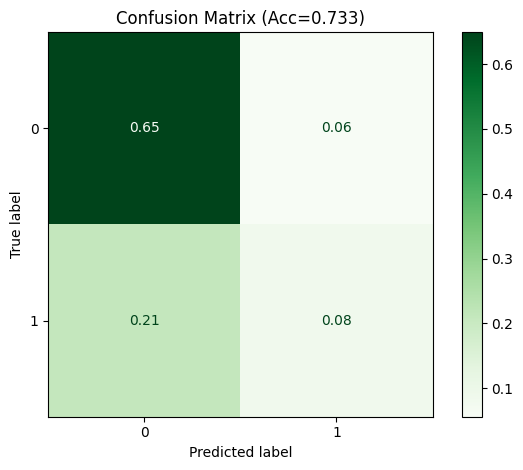

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test)
acc = accuracy_score(y_test, y_pred_test)

# Normalize to percentages of total
cm_norm = cm / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["0", "1"])
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Greens", values_format=".2f", colorbar=True)

ax.set_title(f"Confusion Matrix (Acc={acc:.3f})")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

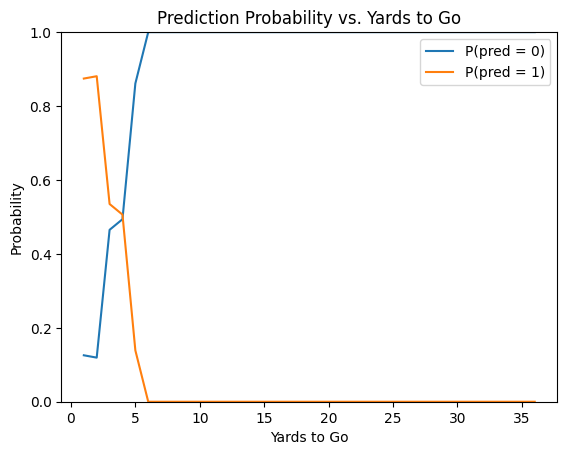

In [17]:
line_data = pd.crosstab(X_test["ydstogo"], y_pred_test, normalize="index").sort_index()

plt.figure()
plt.plot(line_data.index, line_data.get(0, 0), label="P(pred = 0)")
plt.plot(line_data.index, line_data.get(1, 0), label="P(pred = 1)")

plt.title("Prediction Probability vs. Yards to Go")
plt.xlabel("Yards to Go")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [18]:
# With "junk plays"
final_model_2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(C=best_C, max_iter=1000))
])

final_model_2.fit(X_train_2, y_train_2)

# test evaluation
y_pred_test_2 = final_model_2.predict(X_test_2)

print("Test accuracy:", accuracy_score(y_test_2, y_pred_test_2))
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_test_2, y_pred_test_2))


Test accuracy: 0.7514278619319593
Confusion matrix [[TN, FP],[FN, TP]]:
 [[5506  388]
 [1614  546]]


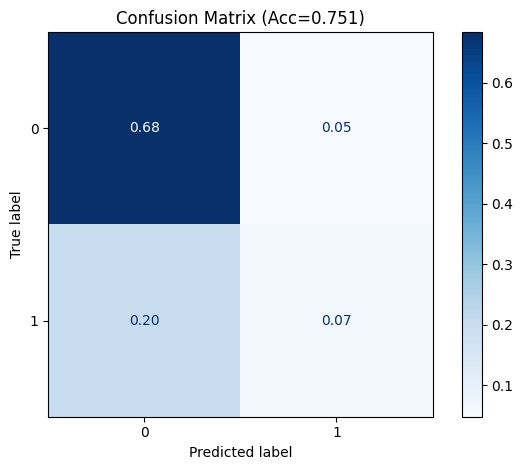

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_2, y_pred_test_2)
acc = accuracy_score(y_test_2, y_pred_test_2)

# Normalize to percentages of total
cm_norm = cm / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["0", "1"])
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)

ax.set_title(f"Confusion Matrix (Acc={acc:.3f})")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

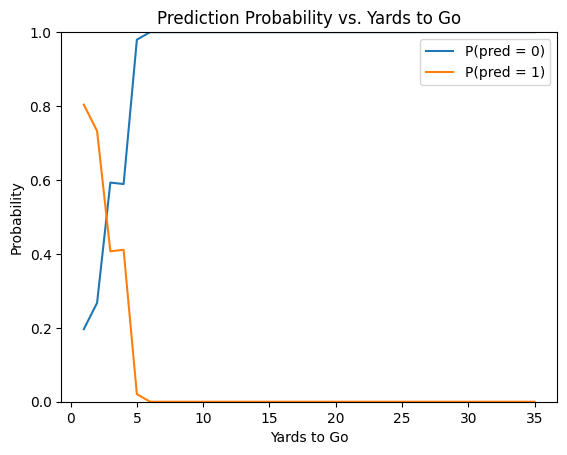

In [20]:
line_data = pd.crosstab(X_test_2["ydstogo"], y_pred_test_2, normalize="index").sort_index()

plt.figure()
plt.plot(line_data.index, line_data.get(0, 0), label="P(pred = 0)")
plt.plot(line_data.index, line_data.get(1, 0), label="P(pred = 1)")

plt.title("Prediction Probability vs. Yards to Go")
plt.xlabel("Yards to Go")
plt.ylabel("Probability")
plt.ylim(0, 1)
#plt.xlim(0, 20)
plt.legend()
plt.show()


Interpreting the results for Model 1: 

4429 is True Negative, these are plays that did not result in first downs and were predicted to not result in first downs. 

382 is False Postitive, these are plays that did not result in a first down, but our model predicted that they did.

1437 is False Negative, these are plays that resulted in a first down, but our model predicted that they would not.

577 is True Positive, these are plays that resulted in a first down that our model predicted would be a first down. 

Our overall Accuracy on our model is 73%. Had we just predicted no first down for all plays, our model would have an overall accuracy of 70%, which means we are outperforming our base case, but not by as much as we would hope.

We can also look at an ROC curve for a better understanding of the accuracy

In [21]:
cm = confusion_matrix(y_test, y_pred_test)  # [[TN, FP],[FN, TP]]
tn, fp, fn, tp = cm.ravel()

acc = accuracy_score(y_test, y_pred_test)
fpr = fp / (fp + tn) if (fp + tn) else 0.0   # false positive rate
fnr = fn / (fn + tp) if (fn + tp) else 0.0   # false negative rate

print(fpr)
print(fnr)

0.07940137185616296
0.7135054617676266


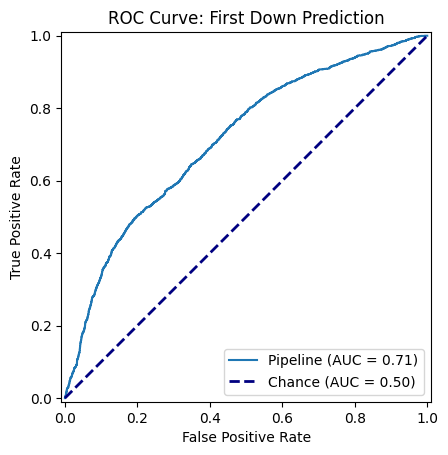

The Area Under the Curve (AUC) is: 0.7107


In [22]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

RocCurveDisplay.from_estimator(model, X_test, y_test)

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance (AUC = 0.50)")

plt.title("ROC Curve: First Down Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

y_prob = model.predict_proba(X_test)[:, 1]
auc_value = roc_auc_score(y_test, y_prob)
print(f"The Area Under the Curve (AUC) is: {auc_value:.4f}")

This ROC AUC demonstrates a 71% chance the model will correctly assign a higher likelihood of success to a randomly chosen play that resulted in a first down compared to one that resulted in no first down. 
